First we install MPHvect from the repository

In [ ]:
#!pip uninstall -y MPHvect
!pip install git+https://github.com/ZachTRoss/MPHvect.git


  Cloning https://github.com/ZachTRoss/MPHvect.git to /private/var/folders/9c/fyzhdwb93mj_2s9x_7254jvm0000gn/T/pip-req-build-2bide9pb
  Running command git clone --filter=blob:none --quiet https://github.com/ZachTRoss/MPHvect.git /private/var/folders/9c/fyzhdwb93mj_2s9x_7254jvm0000gn/T/pip-req-build-2bide9pb
  Resolved https://github.com/ZachTRoss/MPHvect.git to commit 4785d7008b9c8c74fd6978923bbf8f30df821a6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for MPHvect: filename=mphvect-0.1.0-py3-none-any.whl size=7763 sha256=e3ce4728ee2bf93381ce54ff9a3a59029575db4d88bcf1d8df1535bd60ee89ee
  Stored in directory: /private/var/folders/9c/fyzhdwb93mj_2s9x_7254jvm0000gn/T/pip-ephem-wheel-cache-m85k0tmg/wheels/0d/39/17/cf9fc7ace41f570c3079aa251bf0f94345a5165ad17f8af2dd
Successfully built MPHvect

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install -

If you haven't already, you should install multipers and numba on your environment for this example file.

In [ ]:

!pip install multipers
!pip install Numba


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
try:
    import numba
    print("Numba is installed", numba.__version__)
except ImportError:
    print("Numba is not installed")

Numba is installed 0.61.2


In [ ]:
#importing our functions from MPHvect
from MPHvect.method import*


In [ ]:
#importing other tools used in this example file
import numba

from ripser import ripser



from sklearn.neighbors import KernelDensity



import gudhi as gd
from gudhi.representations import Landscape

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.spatial import cKDTree
from mpl_toolkits.mplot3d import Axes3D
import random
import numpy as np
import sys, math

import multipers as mp
from multipers.filtrations.density import KDE
import multipers.plots as mpp
from multipers.filtrations import RipsLowerstar, RipsCodensity
import multipers.plots as mpp


[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library 'libomp' not found.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


Below we define some sampling methods for this example file.

In [ ]:
#Sampling Methods

def sample_annulus(
    n_points,
    center=(0.0, 0.0),
    r_inner=1.0,
    r_outer=2.0,
    random_state=None
):
    """
    Sample points uniformly from a 2D annulus.

    Parameters
    ----------
    n_points : int
        Number of points to sample.
    center : tuple of float
        (x, y) center of the annulus.
    r_inner : float
        Inner radius (>= 0).
    r_outer : float
        Outer radius (> r_inner).
    random_state : int or None
        Seed for reproducibility.

    Returns
    -------
    points : ndarray, shape (n_points, 2)
        Sampled points.
    """
    if r_inner < 0 or r_outer <= r_inner:
        raise ValueError("Require 0 <= r_inner < r_outer")

    rng = np.random.default_rng(random_state)

    # Sample angle uniformly
    theta = rng.uniform(0.0, 2.0 * np.pi, size=n_points)

    # Sample radius with area correction
    u = rng.uniform(0.0, 1.0, size=n_points)
    r = np.sqrt((r_outer**2 - r_inner**2) * u + r_inner**2)

    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)

    return np.column_stack((x, y))


def sample_disc(
        n_points,
        center=(0.0, 0.0),
        radius=0.5,
        random_state=None
    ):
        """
        Sample points uniformly from a 2D disc.

        Parameters
        ----------
        n_points : int
            Number of points to sample.
        center : tuple of float
            (x, y) center of the annulus.
        r_inner : float
            Inner radius (>= 0).
        r_outer : float
            Outer radius (> r_inner).
        random_state : int or None
            Seed for reproducibility.

        Returns
        -------
        points : ndarray, shape (n_points, 2)
            Sampled points.
        """
        if radius <0:
            raise ValueError("Require 0 <= radius")

        rng = np.random.default_rng(random_state)

        # Sample angle uniformly
        theta = rng.uniform(0.0, 2.0 * np.pi, size=n_points)

        # Sample radius with area correction
        u = rng.uniform(0.0, 1.0, size=n_points)
        r = radius * u

        x = center[0] + r * np.cos(theta)
        y = center[1] + r * np.sin(theta)

        return np.column_stack((x, y))


def sample_rand_annulus(annulus_inner_radius, annulus_outer_radius, n_points, noise_factor):

  n_annulus = math.ceil((1-noise_factor)*n_points)
  n_noise=n_points-n_annulus

  rng = np.random.default_rng()

  #annulus_center_x = rng.uniform(-1.2,1.2)
  #annulus_center_y = rng.uniform(-1.2,1.2)

  annulus_points=sample_annulus(n_annulus, center=(0,0), r_inner=annulus_inner_radius, r_outer=annulus_outer_radius)

  noise_limit=1.5*annulus_outer_radius

  noise_points=np.random.uniform(-noise_limit,noise_limit,(n_noise,2))
  #noise_points_shift=noise_points+np.array([annulus_center_x,annulus_center_y])
  return np.concatenate((annulus_points, noise_points), axis=0)

def sample_rand_disc(disc_radius, n_points, noise_factor):

  n_disc = math.ceil((1-noise_factor)*n_points)
  n_noise=n_points-n_disc

  rng = np.random.default_rng()

  #disc_center_x = rng.uniform(-1.2,1.2)
  #disc_center_y = rng.uniform(-1.2,1.2)

  disc_points=sample_disc(n_disc, (0,0), disc_radius)

  noise_limit=1.5*disc_radius

  noise_points=np.random.uniform(-noise_limit,noise_limit,(n_noise,2))
  #noise_points_shift=noise_points+np.array([annulus_center_x,annulus_center_y])
  return np.concatenate((disc_points, noise_points), axis=0)


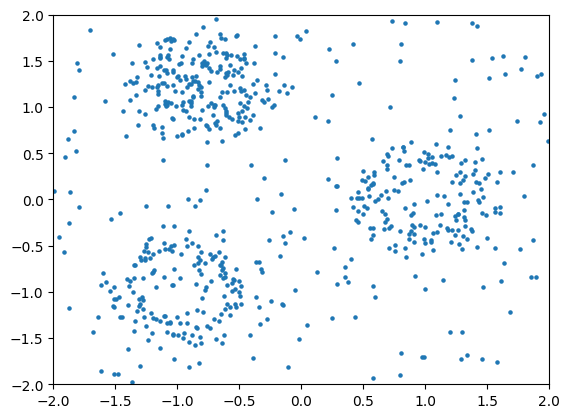

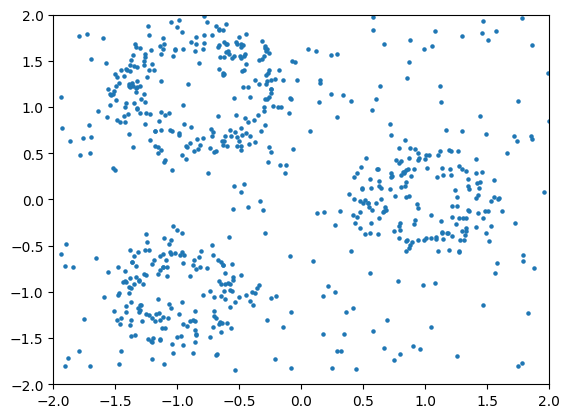

In [ ]:
#make sampling method


def sample_annulus(n_points, r_inner, r_outer, noise=0.0, center=(0,0)):
    """
    Sample points uniformly from an annulus with inner radius r_inner and outer radius r_outer.
    Optionally add Gaussian noise.
    """
    theta = np.random.uniform(0, 2*np.pi, n_points)
    r = np.sqrt(np.random.uniform(r_inner**2, r_outer**2, n_points))
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    points = np.column_stack([x, y])

    if noise > 0:
        points += np.random.normal(scale=noise, size=points.shape)

    return points

def sample_disk(n_points, radius, noise=0.0, center=(0,0)):
    """
    Sample points uniformly from a disk with given radius.
    Optionally add Gaussian noise.
    """
    theta = np.random.uniform(0, 2*np.pi, n_points)
    r = np.sqrt(np.random.uniform(0, radius**2, n_points))
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    points = np.column_stack([x, y])

    if noise > 0:
        points += np.random.normal(scale=noise, size=points.shape)

    return points

def generate_two_annuli_and_disk(n, r11,r12,r21, r22,r3,noise=0.05):
    """

    Generate points for two non-overlapping annuli and a disk.
    """
    anti_noise_prop=0.7
    area1=(np.pi*(r12**2-r11**2))
    area2=(np.pi*(r22**2-r21**2))
    area3=(np.pi*(r3**2))
    total_area=area1+area2+area3
    n1 = int(n*anti_noise_prop*area1/total_area)
    n2 = int(n*anti_noise_prop*area2/total_area)
    n_disk = int(n*anti_noise_prop*area3/total_area)
    n_noise=n-n1-n2-n_disk
    #print(n1, n2, n_disk, n_noise)
    # Annulus 1 (centered at origin)
    annulus1 = sample_annulus(n1, r_inner=r11, r_outer=r12, noise=noise, center=(-1,-1))

    # Annulus 2 (shifted so it does not overlap)
    annulus2 = sample_annulus(n2, r_inner=r21, r_outer=r22, noise=noise, center=(1,0))

    # Disk (shifted so it does not overlap)
    disk_points = sample_disk(n_disk, radius=r3, noise=noise, center=(-0.8,1.2))
    more_noise= np.random.uniform(low=-2, high=2, size=(n_noise,2))
    # Combine all points
    return np.vstack([annulus1, annulus2, disk_points, more_noise])

# Example usage
points = generate_two_annuli_and_disk(700,0.3,0.55, 0.3, 0.55, 0.536, noise=0.10)

# Optional: visualize
import matplotlib.pyplot as plt
plt.scatter(points[:,0], points[:,1], s=5)
plt.axis([-2,2,-2,2])
plt.show()


def generate_three_annuli(n, r11, r12, r21, r22, r31, r32, noise=0.05):
    """

    Generate points for two non-overlapping annuli and a disk.
    """
    anti_noise_prop=0.7
    area1=(np.pi*(r12**2-r11**2))
    area2=(np.pi*(r22**2-r21**2))
    area3=(np.pi*(r32**2-r31**2))
    total_area=area1+area2+area3
    n1 = int(n*anti_noise_prop*area1/total_area)
    n2 = int(n*anti_noise_prop*area2/total_area)
    n3= int(n*anti_noise_prop*area3/total_area)
    n_noise=n-n1-n2-n3

    #print(n1, n2, n3, n_noise)
    # Annulus 1 (centered at origin)
    annulus1 = sample_annulus(n1, r_inner=r11, r_outer=r12, noise=noise, center=(-1,-1))

    # Annulus 2 (shifted so it does not overlap)
    annulus2 = sample_annulus(n2, r_inner=r21, r_outer=r22, noise=noise, center=(1,0))

    # Disk (shifted so it does not overlap)
    annulus3= sample_annulus(n3, r_inner=r31, r_outer=r32, noise=noise, center=(-0.8,1.2))
    more_noise= np.random.uniform(low=-2, high=2, size=(n_noise,2))
    # Combine all points
    return np.vstack([annulus1, annulus2, annulus3, more_noise])

# Example usage
points = generate_three_annuli(700,0.3,0.55, 0.3, 0.55, 0.45, 0.7, noise=0.10)
plt.scatter(points[:,0], points[:,1], s=5)
plt.axis([-2,2,-2,2])
plt.show()

Text(0.5, 1.0, 'Three annulus dataset (size 700)')

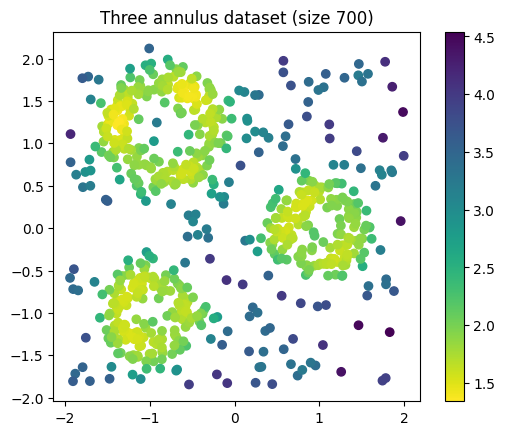

In [ ]:
#we will generate a bi-filtration of simplicial complexes whose vertices are these data points

density = KDE(bandwidth=0.15, return_log=True).fit(points).score_samples(points)
#kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(X)
#density = kde.score_samples(X)
plt.scatter(*points.T, c = -density, cmap="viridis_r")
plt.gca().set_aspect(1); plt.colorbar()
plt.title(f"Three annulus dataset (size {points.shape[0]})")

SVM Experiment for Multipers and MPHvect

In [ ]:
#Here we generate 50 samplings of two classes of data. Each sampling of the first class consists of points sampled from 3 annuli, with random noise added in. Each sampling in the second class consists of poitns sampled from 2 annuli and one disc, with random noise added. (Both classes illustrated above)
iterations=50
number_of_points=700
Class_Annulus=[]
Class_Disc=[]

for i in range(iterations):
  np.random.seed(i)
  #rng = np.random.default_rng()
  #rand_noise=rng.uniform(0.4,0.7)
  double_points=generate_two_annuli_and_disk(number_of_points,0.3,0.55, 0.3,0.55, 0.536, noise=0.2)

  Class_Disc.append(double_points)


  triple_points = generate_three_annuli(number_of_points,0.3,0.55, 0.3, 0.55, 0.45, 0.7, noise=0.2)
  #rand_noise=rng.uniform(0.2,0.4)
  #triple_points=sample_rand_annulus(0.45, 0.7, number_of_points, rand_noise)
  Class_Annulus.append(triple_points)

  sys.stdout.write(f"\rCompleted {i+1}/{iterations}")
  sys.stdout.flush()
print()

Completed 50/50


Testing SVM Classification of 1-Parameter Persistence and Persistence Landscapes

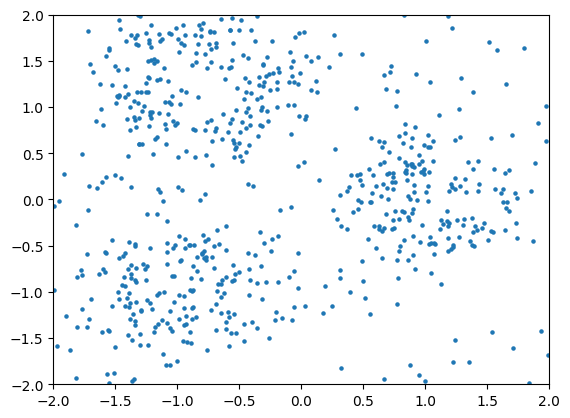

[0.00000000e+00 2.27769314e-06 3.41464270e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
(5, 500)


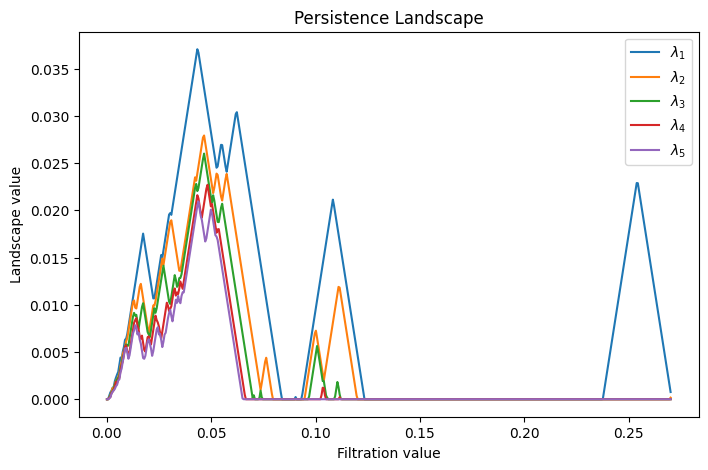

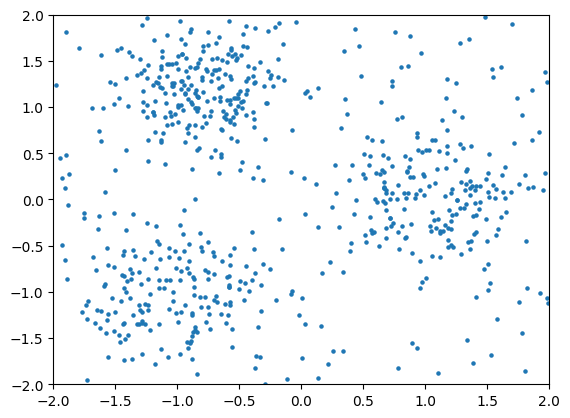

[9.86600908e-05 3.72818829e-04 5.38619680e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
(5, 500)


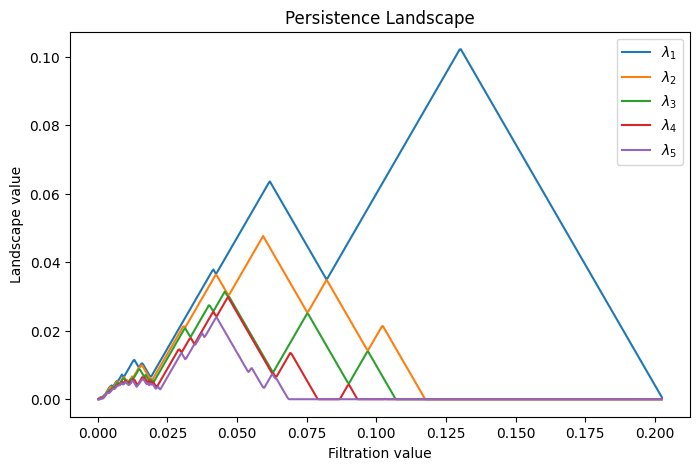

In [ ]:
points=Class_Annulus[0]

plt.scatter(points[:,0], points[:,1], s=5)
plt.axis([-2,2,-2,2])
plt.show()

alpha = gd.AlphaComplex(points=points)
st = alpha.create_simplex_tree()

st.persistence()


H1 = st.persistence_intervals_in_dimension(1)


landscape = Landscape(resolution=500, num_landscapes=5)
L = landscape.fit_transform([H1])[0]
print(L)
L = L.reshape(5, 500)
print(L.shape)
# Manual domain
bmin = H1[:,0].min()
dmax = H1[:,1].max()
t = np.linspace(bmin, dmax, 500)

plt.figure(figsize=(8,5))
for k in range(5):
    plt.plot(t, L[k], label=f"$\lambda_{k+1}$")

plt.xlabel("Filtration value")
plt.ylabel("Landscape value")
plt.title("Persistence Landscape")
plt.legend()
plt.show()


points=Class_Disc[0]

plt.scatter(points[:,0], points[:,1], s=5)
plt.axis([-2,2,-2,2])
plt.show()

alpha = gd.AlphaComplex(points=points)
st = alpha.create_simplex_tree()

st.persistence()


H1 = st.persistence_intervals_in_dimension(1)


landscape = Landscape(resolution=500, num_landscapes=5)
L = landscape.fit_transform([H1])[0]
print(L)
L = L.reshape(5, 500)
print(L.shape)
# Manual domain
bmin = H1[:,0].min()
dmax = H1[:,1].max()
t = np.linspace(bmin, dmax, 500)

plt.figure(figsize=(8,5))
for k in range(5):
    plt.plot(t, L[k], label=f"$\lambda_{k+1}$")

plt.xlabel("Filtration value")
plt.ylabel("Landscape value")
plt.title("Persistence Landscape")
plt.legend()
plt.show()



In [ ]:
def compute_landscapes(points):
  alpha = gd.AlphaComplex(points=points)
  st = alpha.create_simplex_tree()

  st.persistence()


  H1 = st.persistence_intervals_in_dimension(1)


  landscape = Landscape(resolution=500, num_landscapes=5)
  L = landscape.fit_transform([H1])[0]
  return L

In [ ]:
Landscape_Ann=[]
Landscape_Dis=[]
for i in range(iterations):
  points=Class_Annulus[i]
  Landscape_Ann.append(compute_landscapes(points))

  points=Class_Disc[i]
  Landscape_Dis.append(compute_landscapes(points))

  sys.stdout.write(f"\rCompleted {i+1}/{iterations}")
  sys.stdout.flush()
print()

Completed 50/50


Below we plot the average persistence landscape of each class, as well as the difference of the two averages


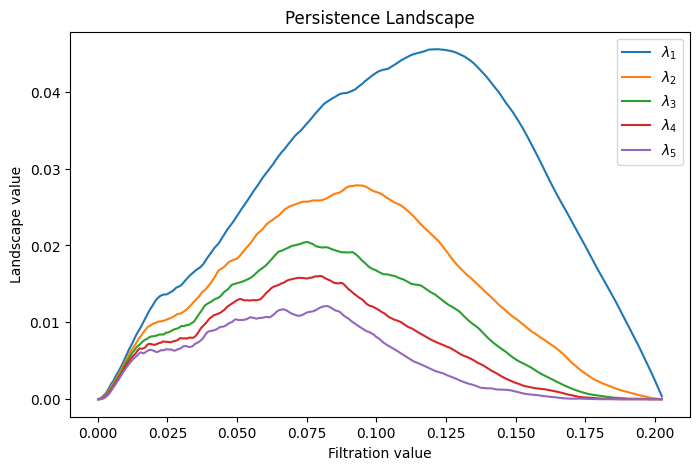

(50, 2500)


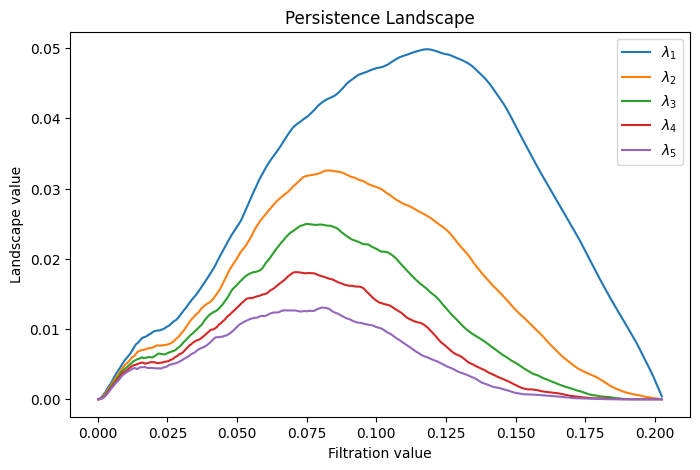

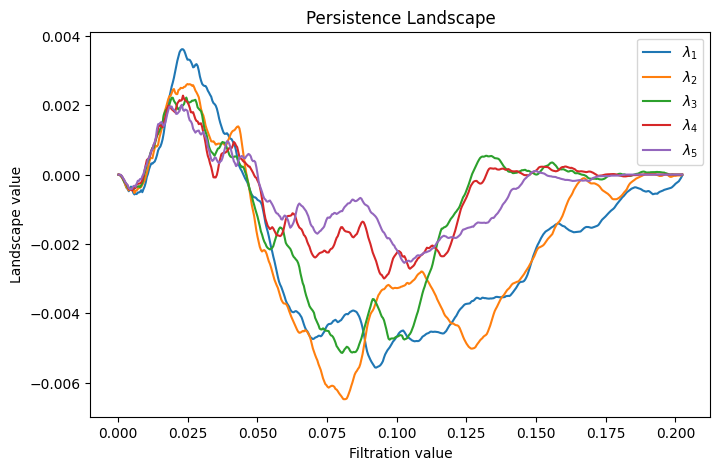

In [ ]:
L_Ann_stack = np.vstack(Landscape_Ann)   # shape: (50, D)
L_Ann_avg_flat = L_Ann_stack.mean(axis=0)      # shape: (D,)
L_Ann_avg = L_Ann_avg_flat.reshape(5, 500)

# Manual domain
bmin = H1[:,0].min()
dmax = H1[:,1].max()
t = np.linspace(bmin, dmax, 500)

plt.figure(figsize=(8,5))
for k in range(5):
    plt.plot(t, L_Ann_avg[k], label=f"$\lambda_{k+1}$")

plt.xlabel("Filtration value")
plt.ylabel("Landscape value")
plt.title("Persistence Landscape")
plt.legend()
plt.show()



L_Dis_stack = np.vstack(Landscape_Dis)
print(L_Dis_stack.shape)  # shape: (50, D)
L_Dis_avg_flat = L_Dis_stack.mean(axis=0)      # shape: (D,)

L_Dis_avg = L_Dis_avg_flat.reshape(5, 500)

# Manual domain
bmin = H1[:,0].min()
dmax = H1[:,1].max()
t = np.linspace(bmin, dmax, 500)

plt.figure(figsize=(8,5))
for k in range(5):
    plt.plot(t, L_Dis_avg[k], label=f"$\lambda_{k+1}$")

plt.xlabel("Filtration value")
plt.ylabel("Landscape value")
plt.title("Persistence Landscape")
plt.legend()
plt.show()

L_dif=L_Ann_avg-L_Dis_avg
bmin = H1[:,0].min()
dmax = H1[:,1].max()
t = np.linspace(bmin, dmax, 500)

plt.figure(figsize=(8,5))
for k in range(5):
    plt.plot(t, L_dif[k], label=f"$\lambda_{k+1}$")

plt.xlabel("Filtration value")
plt.ylabel("Landscape value")
plt.title("Persistence Landscape")
plt.legend()
plt.show()


0.47000000000000003
0.1


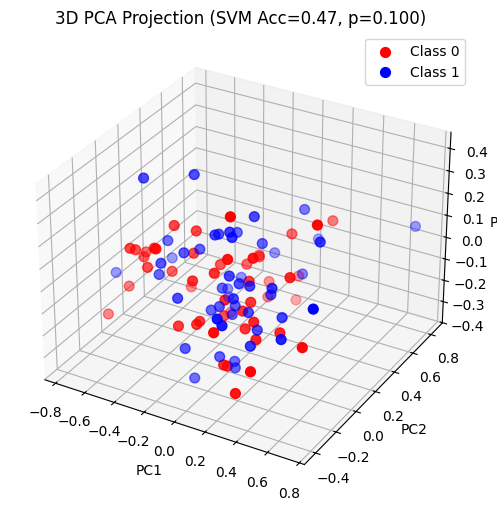

In [ ]:
#Here we compute a support vector machine classification test, and print the accuracy and p-value, as well as plot the 3D PCA projection
do_SVM_and_PCA(Landscape_Ann, Landscape_Dis)

Now we Calculate Signed Barcodes using the Multipers package by David Loiseaux and Hannah Schreiber

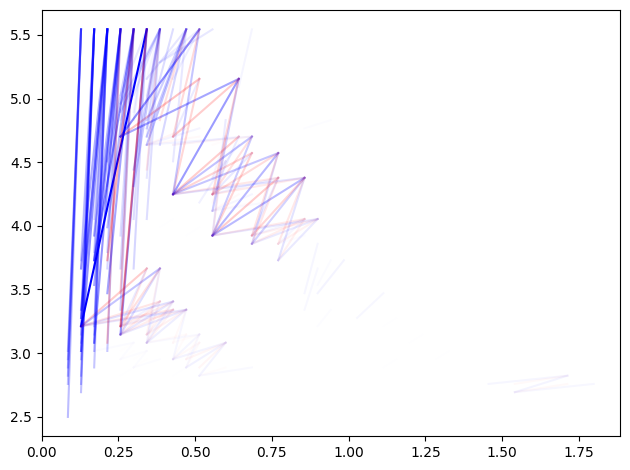

In [ ]:



points=Class_Annulus[0]

density = KDE(bandwidth=0.15, return_log=True).fit(points).score_samples(points)
simplextree = RipsLowerstar(points=points, function = 1-density, threshold_radius=2.5) # this is a simplicial complex
simplextree.collapse_edges(-2)                             # Removes some unnecessary edges (while staying quasi isomorphic)
simplextree.expansion(2)                                   # Adds the 2-simplices (necessary for $H_1$ computations)
simplextree.prune_above_dimension(2) ## The simplices above dimension 2 are not necessary here; this speeds up the computations.
grid = mp.grids.compute_grid( ## Computes a subgrid
    simplextree,
    strategy="regular", # i.e., will return a regular grid
    resolution=50,
)
rank_sm = mp.signed_measure(
    simplextree.grid_squeeze(grid), # we coarsen the simplextree before feeding it to the invariant computation
    degree=1,
    invariant = "rank", # The default one is using rectangle decompositions.
    plot = True,
);



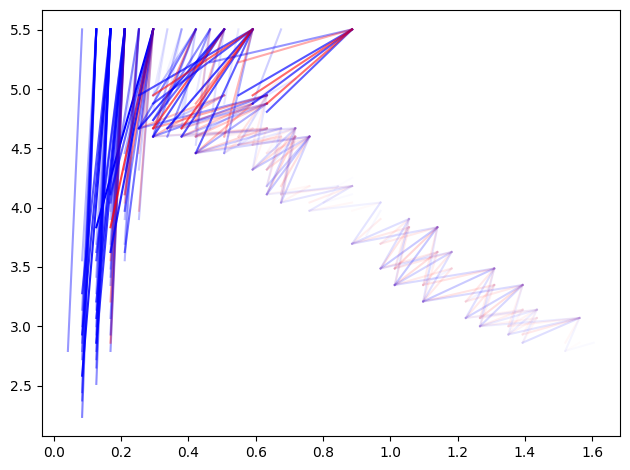

In [ ]:
points=Class_Disc[0]

density = KDE(bandwidth=0.15, return_log=True).fit(points).score_samples(points)
simplextree = RipsLowerstar(points=points, function = 1-density, threshold_radius=2.5) # this is a simplicial complex
simplextree.collapse_edges(-2)                             # Removes some unnecessary edges (while staying quasi isomorphic)
simplextree.expansion(2)                                   # Adds the 2-simplices (necessary for $H_1$ computations)
simplextree.prune_above_dimension(2) ## The simplices above dimension 2 are not necessary here; this speeds up the computations.
grid = mp.grids.compute_grid( ## Computes a subgrid
    simplextree,
    strategy="regular", # i.e., will return a regular grid
    resolution=50,
)
rank_sm = mp.signed_measure(
    simplextree.grid_squeeze(grid), # we coarsen the simplextree before feeding it to the invariant computation
    degree=1,
    invariant = "rank", # The default one is using rectangle decompositions.
    plot = True,
);

In [ ]:
#Now compute signed barcodes



class1_barcodes=[]
for i, points in enumerate(Class_Annulus):
  density = KDE(bandwidth=0.15, return_log=True).fit(points).score_samples(points)
  simplextree = RipsLowerstar(points=points, function = 1-density, threshold_radius=2.5)
  simplextree.collapse_edges(-2)
  simplextree.expansion(2)
  simplextree.prune_above_dimension(2)
  grid = mp.grids.compute_grid(
      simplextree,
      strategy="regular",
      resolution=50,
  )
  rank_sm = mp.signed_measure(
      simplextree.grid_squeeze(grid),
      degree=1,
      invariant = "rank",
      plot = False,
  );
  class1_barcodes.append(rank_sm[0])
  sys.stdout.write(f"\rCompleted {i+1}/{iterations}")
  sys.stdout.flush()

print()




class2_barcodes=[]
for i, points in enumerate(Class_Disc):
  density = KDE(bandwidth=0.15, return_log=True).fit(points).score_samples(points)
  simplextree = RipsLowerstar(points=points, function = 1-density, threshold_radius=2.5)
  simplextree.collapse_edges(-2)
  simplextree.expansion(2)
  simplextree.prune_above_dimension(2)
  grid = mp.grids.compute_grid(
      simplextree,
      strategy="regular",
      resolution=50,
  )
  rank_sm = mp.signed_measure(
      simplextree.grid_squeeze(grid),
      degree=1,
      invariant = "rank",
      plot = False,
  );
  class2_barcodes.append(rank_sm[0])
  sys.stdout.write(f"\rCompleted {i+1}/{iterations}")
  sys.stdout.flush()

print()

Completed 50/50
Completed 50/50


In [ ]:
def replace_inf_safe(barcode):
    vectors_copy=barcode.copy()
    for arr in vectors_copy:
        arr[np.isinf(arr)] = 1
    return vectors_copy

In [ ]:
#Here, we normalize the barcodes to fit inside the unit 4D-cube *0.9. Then we replace infinite values with 1

max_val_1=max(max(arr[np.isfinite(arr)].max() for arr in barcode[0]) for barcode in class1_barcodes)
max_val_2=max(max(arr[np.isfinite(arr)].max() for arr in barcode[0]) for barcode in class2_barcodes)
max_val=max(max_val_1,max_val_2)
print(max_val)
for i,b in enumerate(class1_barcodes):
    bars,mults=b
    penultimate_bars=0.9*(max_val**-1)*bars
    normed_bars=replace_inf_safe(penultimate_bars)

    class1_barcodes[i]=(normed_bars,mults)
    sys.stdout.write(f"\rCompleted {i+1}/{iterations}")
    sys.stdout.flush()
print()

for i,b in enumerate(class2_barcodes):
    bars,mults=b
    #max_val = max(arr[np.isfinite(arr)].max() for arr in bars)

    penultimate_bars=0.9*(max_val**-1)*bars
    normed_bars=replace_inf_safe(penultimate_bars)
    class2_barcodes[i]=(normed_bars,mults)
    sys.stdout.write(f"\rCompleted {i+1}/{iterations}")
    sys.stdout.flush()
print()

max_val_1=max(max(arr[np.isfinite(arr)].max() for arr in barcode[0]) for barcode in class1_barcodes)
max_val_2=max(max(arr[np.isfinite(arr)].max() for arr in barcode[0]) for barcode in class2_barcodes)
max_val=max(max_val_1,max_val_2)
print(max_val)

5.5922744941337585
Completed 50/50
Completed 50/50
1.0


In [ ]:
#Now vectorize all these barcodes using MPHvect. We first generate indexing lists to determine how many functionals we use of the Schauder Basis in order to vectorize signed barcodes. This is done using collect_vertices. (this is done outside of numba).
#The first input of collecti_vertices is the number of persistence parameters (2 in this case).
#The second input is the number of refinements we take of the Coxeter-Freudenthal-Kuhn triangulation of parameter space. Increasing this can improve accuracy but also increases computation time.
#This takes about 30 minutes for iterations=50 (if max layer =5 and you're using numba)


n_list, p_list=collect_vertices(2, 5)
print("List Generated")



class1_vectors=[]
for i,barcode in enumerate(class1_barcodes):
  class1_vectors.append(vectorize_fast(n_list, p_list, barcode[0], barcode[1]))
  sys.stdout.write(f"\rCompleted {i+1}/{iterations}")
  sys.stdout.flush()
print()

class2_vectors=[]
for i,barcode in enumerate(class2_barcodes):
  class2_vectors.append(vectorize_fast(n_list, p_list, barcode[0], barcode[1]))
  sys.stdout.write(f"\rCompleted {i+1}/{iterations}")
  sys.stdout.flush()
print()



List Generated
Completed 50/50
Completed 50/50


0.9700000000000001
0.0


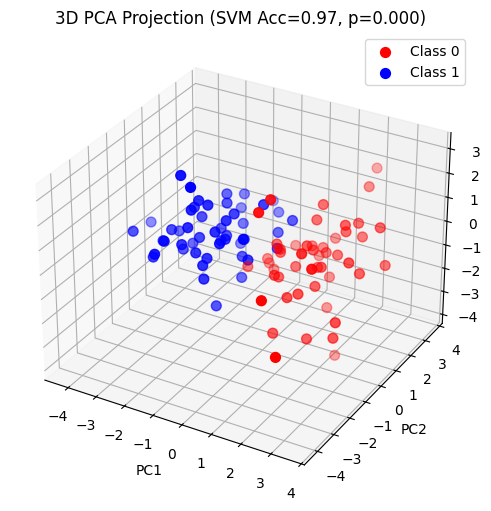

In [ ]:
do_SVM_and_PCA(class1_vectors, class2_vectors)